# NVDA Heston Model Calibration Demo

This notebook demonstrates the Heston model calibration using real NVDA options data from Yahoo Finance.

In [2]:
# Force reload the calibrator module to pick up recent changes
import importlib
import sys

# Add the parent directory (src) to Python path so heston_calib package can be found
project_root = r'C:\Users\Ao Shen\Desktop\mfin research\src'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Remove the module from cache if it exists
if 'heston_calib.quantlib_heston_calibrator' in sys.modules:
    del sys.modules['heston_calib.quantlib_heston_calibrator']   
if 'heston_calib.market_data_fetcher' in sys.modules:
    del sys.modules['heston_calib.market_data_fetcher']
if 'heston_calib' in sys.modules:
    del sys.modules['heston_calib']

from heston_calib.quantlib_heston_calibrator import QuantLibHestonCalibrator
from heston_calib.market_data_fetcher import MarketDataFetcher

## Setup and Configuration

In [3]:
# Import required libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
import warnings
warnings.filterwarnings('ignore')

# Add the parent directory (src) to Python path so heston_calib package can be found
project_root = r'C:\Users\Ao Shen\Desktop\mfin research\src'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to path: {project_root}")

# Import custom modules (now heston_calib should be found as a package)
from heston_calib.market_data_fetcher import MarketDataFetcher
from heston_calib.quantlib_heston_calibrator import QuantLibHestonCalibrator

print(f"Setup complete - QuantLib v{ql.__version__}")

Added to path: C:\Users\Ao Shen\Desktop\mfin research\src
Setup complete - QuantLib v1.39


In [4]:
# Configuration
TICKER = 'NVDA'
EXPIRY_LIST = ['1M', '2M', '3M']  # Use fewer expiries for faster calibration
ATM_RANGE = 0.1  # ±10% around spot for better quality
RISK_FREE_RATE = 0.05  # Updated to current rate
DIVIDEND_YIELD = 0.0
MAX_ITERATIONS = 1000 # More iterations for better convergence

print(f"Target: {TICKER} | Expiries: {EXPIRY_LIST} | ATM Range: ±{ATM_RANGE*100:.0f}%")

Target: NVDA | Expiries: ['1M', '2M', '3M'] | ATM Range: ±10%


## Market Data Fetching

In [5]:
# Fetch market data
fetcher = MarketDataFetcher(
    ticker=TICKER, 
    expiry_list=EXPIRY_LIST, 
    atm_range=ATM_RANGE
)

market_data = fetcher.prepare_market_data()
spot_price = fetcher.get_spot_price()

print(f"Spot: ${spot_price:.2f} | Options: {len(market_data)} | DTE: {market_data['DaysToExpiry'].min()}-{market_data['DaysToExpiry'].max()} days")

# Show first few rows
display(market_data.head(3))

Target 2025-09-23: Found 2025-09-26 (2 days difference)
Target 2025-10-23: Found 2025-10-17 (7 days difference)
Target 2025-11-22: Found 2025-11-21 (2 days difference)
Using specific expiry dates: ['2025-09-26', '2025-10-17', '2025-11-21']
Preparing market data for NVDA
Time range: 2025-08-24 to 2025-11-22
ATM range: ±10.0%
Fetching option data for NVDA...
Fetching specific expiries: ['2025-09-26', '2025-10-17', '2025-11-21']
  Fetched 97 contracts for 2025-09-26
  Fetched 106 contracts for 2025-10-17
  Fetched 104 contracts for 2025-11-21
Fetched 307 raw option contracts
Applying ATM filter...
ATM filter (±10.0% around $177.99) kept 42 of 307 contracts
Strike range: $165.00 to $195.00
Final dataset: 42 contracts across 3 maturities
DTE range: 33 to 89 days
Spot: $177.99 | Options: 42 | DTE: 33-89 days


,OptionType,Strike,DaysToExpiry,MarketPrice,ImpliedVolatility
21,call,165.0,33,18.275,0.505010
22,call,170.0,33,14.450,0.472539
23,call,175.0,33,11.350,0.457891


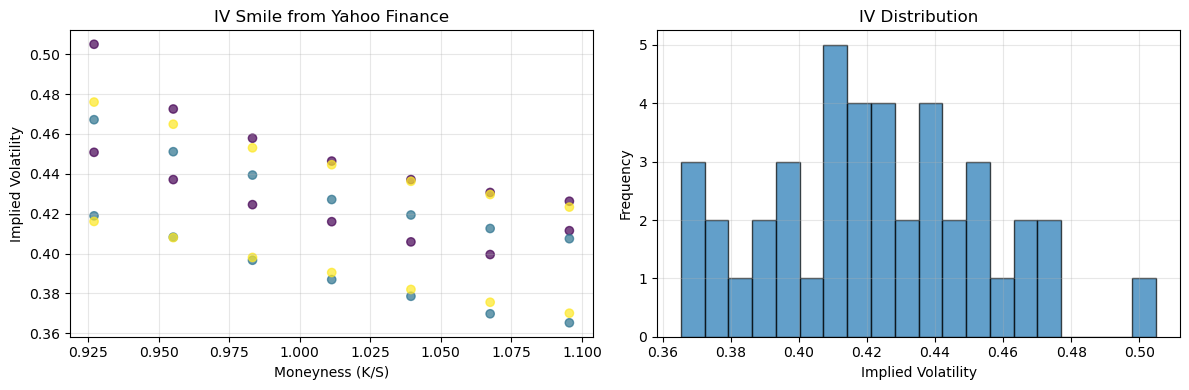

In [6]:
if 'ImpliedVolatility' in market_data.columns:
    # Show IV distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # IV by moneyness
    market_data['Moneyness'] = market_data.Strike / spot_price
    ax1.scatter(market_data.Moneyness, market_data.ImpliedVolatility, 
               c=market_data.DaysToExpiry, cmap='viridis', alpha=0.7)
    ax1.set_xlabel('Moneyness (K/S)')
    ax1.set_ylabel('Implied Volatility')
    ax1.set_title('IV Smile from Yahoo Finance')
    ax1.grid(True, alpha=0.3)
    
    # IV histogram  
    ax2.hist(market_data.ImpliedVolatility, bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Implied Volatility')
    ax2.set_ylabel('Frequency')
    ax2.set_title('IV Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Heston Model Calibration

In [7]:

calibrator = QuantLibHestonCalibrator(
    r=RISK_FREE_RATE, 
    q=DIVIDEND_YIELD
)

# Enhanced calibration with new features
heston_model, calibration_info = calibrator.calibrate(
    spot=spot_price,
    market_data=market_data,
    maxiter=MAX_ITERATIONS,  # More iterations for proper convergence
    detailed_report=False    # Keep output concise
)

# Print results using the enhanced formatter
calibrator.print_results(calibration_info)

Starting Heston calibration using Differential Evolution...
Market data: 42 options
Trying initial condition: theta=0.090, kappa=2.000, sigma=0.300, rho=-0.700, v0=0.040
Created 42 valid helpers from 42 options
  → Initial cost with these parameters: 5.130365
  → Result: fun=1.683330, nfev=14718
  → NEW BEST solution! Cost: 1.683330
Created 42 valid helpers from 42 options

Calibration successful with initial condition: (0.09, 2.0, 0.3, -0.7, 0.04)
Iterations: 193, Function evaluations: 14718
Final cost: 1.683330

HESTON CALIBRATION RESULTS
Options used: 42, Average error: 6.7467%

Parameters:
  theta (θ): 0.2036  |  kappa (κ): 5.9351
  sigma (σ): 3.9905  |  rho (ρ):   -0.2737
  v0:        0.2674

Volatilities: Initial 51.71%, Long-term 45.12%


## IV Surface Reconstruction

In [8]:
# Reconstruct IV surface for model validation using Yahoo Finance IV
if not calibration_info['success']:
    raise ValueError("Calibration failed")

heston_engine = ql.AnalyticHestonEngine(heston_model)
iv_comparison_results = []

print("IV Surface Reconstruction:")
print(f"Market data shape: {market_data.shape}")

successful = 0

for idx, (_, row) in enumerate(market_data.iterrows()):
    try:
        time_to_expiry = row.DaysToExpiry / 365.0
        
        # Use Yahoo Finance IV directly
        market_iv = row.ImpliedVolatility if 'ImpliedVolatility' in row else 0.20
        
        if market_iv < 0.05 or market_iv > 2.0:
            continue
            
        # Create option for Heston pricing
        is_call = row.OptionType.lower() == 'call'
        option_type = ql.Option.Call if is_call else ql.Option.Put
        
        period = ql.Period(int(row.DaysToExpiry), ql.Days)
        expiry_date = calibrator.evaluation_date + period
        exercise = ql.EuropeanExercise(expiry_date)
        payoff = ql.PlainVanillaPayoff(option_type, float(row.Strike))
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(heston_engine)
        
        heston_price = option.NPV()
        
        if heston_price > 0.01:
            # Calculate implied vol from Heston price
            heston_iv = calibrator._calculate_implied_vol(
                heston_price, spot_price, row.Strike, 
                time_to_expiry, row.OptionType
            )
            
            if heston_iv is not None and 0.01 < heston_iv < 5.0:
                iv_comparison_results.append({
                    'Strike': row.Strike,
                    'DaysToExpiry': row.DaysToExpiry,
                    'OptionType': row.OptionType,
                    'MarketIV': market_iv,
                    'HestonIV': heston_iv,
                    'IVDiff': heston_iv - market_iv,
                    'AbsIVError': abs(heston_iv - market_iv)
                })
                successful += 1
                
    except Exception as e:
        continue

iv_comparison_df = pd.DataFrame(iv_comparison_results)

if not iv_comparison_df.empty:
    mean_abs_iv_error = iv_comparison_df['AbsIVError'].mean()
    print(f"\n IV Surface Reconstruction Complete")
    print(f"   • Processed {len(iv_comparison_df)} contracts")
    print(f"   • Mean Absolute IV Error: {mean_abs_iv_error:.4f} ({mean_abs_iv_error*100:.2f}%)")
    print(f"   • Using Yahoo Finance IV for market reference")
    
    display(iv_comparison_df.head(10))
else:
    print("\nNo valid IV comparisons generated")

IV Surface Reconstruction:
Market data shape: (42, 6)

 IV Surface Reconstruction Complete
   • Processed 42 contracts
   • Mean Absolute IV Error: 0.0219 (2.19%)
   • Using Yahoo Finance IV for market reference


,Strike,DaysToExpiry,OptionType,MarketIV,HestonIV,IVDiff,AbsIVError
0,165.0,33,call,0.505010,0.484504,-0.020505,0.020505
1,170.0,33,call,0.472539,0.462132,-0.010408,0.010408
2,175.0,33,call,0.457891,0.443035,-0.014856,0.014856
3,180.0,33,call,0.446417,0.429152,-0.017264,0.017264
4,185.0,33,call,0.437139,0.422092,-0.015048,0.015048
5,190.0,33,call,0.430670,0.421966,-0.008704,0.008704
6,195.0,33,call,0.426275,0.427298,0.001023,0.001023
7,165.0,33,put,0.450811,0.484504,0.033693,0.033693
8,170.0,33,put,0.437139,0.462132,0.024992,0.024992
9,175.0,33,put,0.424566,0.443035,0.018469,0.018469


## Visualization and Analysis

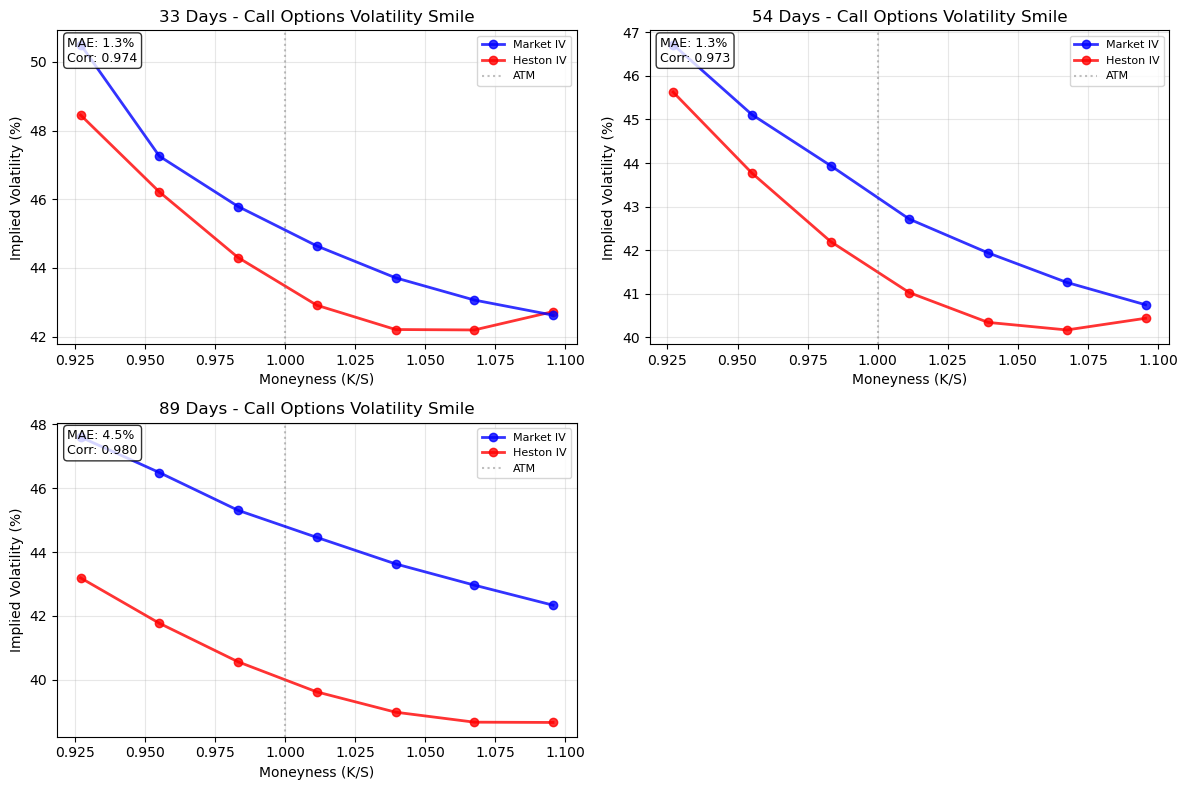


Volatility Smile Analysis (Calls Only):
Expiries analyzed: 3 ([np.int64(33), np.int64(54), np.int64(89)] days)
Call options: 21
Overall MAE: 2.3%
Overall correlation: 0.782
Model Quality: GOOD - Reasonable fit to call volatility smiles


In [9]:
# Volatility Smile Analysis by Expiry (Calls Only) 
if len(iv_comparison_df) > 0:
    # Filter for calls only for cleaner visualization
    calls_only = iv_comparison_df[iv_comparison_df['OptionType'] == 'call'].copy()
    
    if len(calls_only) > 0:
        # Group data by expiry for volatility smile analysis
        expiries = sorted(calls_only['DaysToExpiry'].unique())
        
        # Create subplots for each expiry
        n_expiries = len(expiries)
        cols = min(2, n_expiries)
        rows = (n_expiries + 1) // 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
        if n_expiries == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if cols > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, dte in enumerate(expiries):
            if i >= len(axes):
                break
                
            # Filter data for this expiry
            expiry_data = calls_only[calls_only['DaysToExpiry'] == dte].copy()
            
            if len(expiry_data) < 2:
                continue
                
            # Calculate moneyness (Strike/Spot)
            expiry_data['Moneyness'] = expiry_data['Strike'] / spot_price
            expiry_data = expiry_data.sort_values('Moneyness')
            
            ax = axes[i]
            
            # Plot market IV
            ax.plot(expiry_data['Moneyness'], expiry_data['MarketIV']*100, 
                   'o-', color='blue', linewidth=2, markersize=6, label='Market IV', 
                   alpha=0.8, zorder=3)
            
            # Plot Heston IV
            ax.plot(expiry_data['Moneyness'], expiry_data['HestonIV']*100, 
                   'o-', color='red', linewidth=2, markersize=6, label='Heston IV', 
                   alpha=0.8, zorder=2)
            
            # Add ATM line
            ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='ATM')
            
            # Formatting
            ax.set_xlabel('Moneyness (K/S)')
            ax.set_ylabel('Implied Volatility (%)')
            ax.set_title(f'{dte} Days - Call Options Volatility Smile')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            
            # Add error statistics
            mae = expiry_data['AbsIVError'].mean()
            correlation = expiry_data['MarketIV'].corr(expiry_data['HestonIV'])
            ax.text(0.02, 0.98, f'MAE: {mae:.1%}\nCorr: {correlation:.3f}', 
                    transform=ax.transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment='top', fontsize=9)
        
        # Hide unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Overall quality assessment
        mae_iv = calls_only['AbsIVError'].mean()
        correlation = calls_only['MarketIV'].corr(calls_only['HestonIV'])
        
        print(f"\nVolatility Smile Analysis (Calls Only):")
        print(f"Expiries analyzed: {len(expiries)} ({expiries} days)")
        print(f"Call options: {len(calls_only)}")
        print(f"Overall MAE: {mae_iv:.1%}")
        print(f"Overall correlation: {correlation:.3f}")
        
        if mae_iv < 0.05 and correlation > 0.8:
            quality = "EXCELLENT - Heston captures call smile patterns very well"
        elif mae_iv < 0.10 and correlation > 0.7:
            quality = "GOOD - Reasonable fit to call volatility smiles"
        else:
            quality = "FAIR - Some deviations from market call smile patterns"
        
        print(f"Model Quality: {quality}")
    
    else:
        print("No call options available for volatility smile analysis")
        
else:
    print("No valid comparisons available for volatility smile analysis")